# TASK 1: 

## Objective was the classify the Disputes efficiently in 5 categories :

### [DUPLICATE_CHARGE,FAILED_TRANSACTION, FRAUD, REFUND_PENDING, OTHERS]

### I tried 3 approaches : 
### (i) regular word match classification (kind of rule based),
### (ii) classifcation using semantic similarity using sentence-transformers/all-MiniLM-L6-v2 (for vector embedding) and cosine similarity to map with appropriate category
### (iii) hybrid classification -> using approach (ii) with 60% weightage and rest 40% weightage is given to fuzzy score -> { Resulted in Accurate classification}

### A final validation is done from transactions file for duplicate check

In [237]:
import pandas as pd

### STEP 1: RETRIEVE CSV FILES

In [238]:
disputes = pd.read_csv('disputes.csv')
#print(disputes)

In [239]:
transactions = pd.read_csv('transactions.csv')
#print(transactions)


In [240]:
merged = disputes.merge(transactions, how = 'left',on = ['customer_id'])

## APPROACH 1

In [241]:
CLASSIFICATION_RULES = {
    'DUPLICATE_CHARGE': ['duplicate', 'twice', 'double', 'multiple times'],
    'FAILED_TRANSACTION': ['failed', 'declined', 'error', 'timeout', 'unsuccessful'],
    'FRAUD': ['unauthorized', 'did not make', 'stolen', 'hack', 'suspicious','unknown'],
    'REFUND_PENDING': ['refund', 'return', 'cancel', 'reverse'],
}

In [242]:
def classify_dispute(description):
    scores = {}
    for category, keywords in CLASSIFICATION_RULES.items():
        score = sum(1 for keyword in keywords if keyword in description.lower())
        scores[category] = score
        max_score = max(scores.values())
    if max_score == 0:
        return 'OTHERS', 0.3
    
    predicted_category = max(scores, key=scores.get)
    confidence = min(0.9, 0.5 + (max_score * 0.2))
    return predicted_category, confidence

In [243]:
# for i in disputes.description:
#     print(i)
#     print(classify_dispute(i))

### APPROACH 2

In [244]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

SEMANTIC_TEMPLATES = {
    'DUPLICATE_CHARGE': [
        "I was charged twice for the same purchase",
        "Double billing for single transaction", 
        "Multiple charges for one order",
        "Transfered two times"
    ],
    'FAILED_TRANSACTION': [
        "Payment failed but money was deducted",
        "Transaction unsuccessful but charged",
        "Payment error occurred"
    ],
    'FRAUD': [
        "Unauthorized transaction on my account",
        "I didn't make this purchase",
        "Someone used my card without permission",
        "This is Fraud",
        "Someone asked for otp and amount got deducted"
    ],
    'REFUND_PENDING':[
        "Didn't received refund yet",
        "Refund not processed",
        "Amount didnt come back"
    ]
}

In [245]:
def semantic_classify(dispute_text):
    dispute_embedding = model.encode([dispute_text])
    
    best_category = None
    best_score = 0
    
    for category, templates in SEMANTIC_TEMPLATES.items():
        template_embeddings = model.encode(templates)
        similarities = cosine_similarity(dispute_embedding, template_embeddings)
        max_similarity = np.max(similarities)
        
        if max_similarity > best_score:
            best_score = max_similarity
            best_category = category
    
    confidence = min(0.95, best_score * 1.2) 
    return best_category, confidence

In [246]:
for i in disputes.description:
    print(i)
    print(semantic_classify(i))

I got charged twice for the same UPI payment
('DUPLICATE_CHARGE', 0.95)
My NEFT failed but money is not refunded
('REFUND_PENDING', np.float32(0.74312127))
Transaction shows failed but money was debited
('FAILED_TRANSACTION', np.float32(0.93448323))
I did not make this payment. This is fraud.
('FRAUD', np.float32(0.79995894))
Still waiting for refund after canceled transaction
('REFUND_PENDING', np.float32(0.88377994))
Duplicate charge for the same merchant within minutes
('DUPLICATE_CHARGE', np.float32(0.8500476))
UPI transfer failed but account is debited
('FAILED_TRANSACTION', np.float32(0.66546696))
NEFT credited to wrong beneficiary per my statement
('FAILED_TRANSACTION', np.float32(0.4576547))
Chargeback requested as I don't recognize this card txn
('FRAUD', np.float32(0.53655744))
Refund pending for a week after failed POS swipe
('REFUND_PENDING', np.float32(0.6725434))
Got two UPI debit messages for one QR scan
('DUPLICATE_CHARGE', np.float32(0.42898792))
Payment stuck in pendi

In [247]:
# semantic_classify("never returned my money u guys")


### APPROACH 3


In [248]:
from fuzzywuzzy import fuzz, process
import re

FUZZY_KEYWORDS = {
    'DUPLICATE_CHARGE': [
        'duplicate', 'double charge', 'charged twice', 'billed twice',
        'multiple charge', 'same transaction', 'repeated payment','debited twice'
    ],
    'FAILED_TRANSACTION': [
        'failed payment', 'transaction failed', 'payment error',
        'declined', 'unsuccessful', 'payment issue','not received'
    ],
    'FRAUD': [
        'unauthorized', 'not authorized', 'didnt make', 'stolen card',
        'fraudulent', 'suspicious', 'unknown transaction'
    ],
    'REFUND_PENDING': [ 
        'not refunded','amount not returned',' return pending'
                      ]
}

def fuzzy_classify(text):
    text_clean = re.sub(r'[^\w\s]', '', text.lower())
    category_scores = {}
    
    for category, keywords in FUZZY_KEYWORDS.items():
        max_fuzzy_score = 0
        for keyword in keywords:
            fuzzy_score = fuzz.partial_ratio(keyword, text_clean)
            token_score = fuzz.token_sort_ratio(keyword, text_clean) #handle spelling error
            
            combined_score = max(fuzzy_score, token_score)
            if combined_score > max_fuzzy_score:
                max_fuzzy_score = combined_score
                best_match = keyword
        
        category_scores[category] = max_fuzzy_score / 100.0
    
    return category_scores

In [250]:
def hybrid_classify(dispute_text,confidence_threshold=0.6):
    
    fuzzy_scores = fuzzy_classify(dispute_text)
    semantic_category, semantic_confidence = semantic_classify(dispute_text)
    
    CATEGORIES = ['DUPLICATE_CHARGE','FAILED_TRANSACTION','FRAUD','REFUND_PENDING']
    final_scores = {}
    
    for category in CATEGORIES:
        fuzzy_weight = 0.4
        semantic_weight = 0.6
        
        fuzzy_score = fuzzy_scores.get(category, 0)
        semantic_score = semantic_confidence if semantic_category == category else 0
        
        final_scores[category] = (fuzzy_weight * fuzzy_score + 
                                 semantic_weight * semantic_score)
    
    best_category = max(final_scores, key=final_scores.get)
    confidence = final_scores[best_category]
    original_category = best_category  
    
    if confidence < confidence_threshold:
        best_category = 'OTHERS'
    
    return (best_category, confidence, 
            {'fuzzy_scores': fuzzy_scores, 'semantic_match': semantic_category},
            semantic_category, semantic_confidence, original_category)

In [259]:
def classify_disputes_batch(df, text_column='description', confidence_threshold=0.6):

    result_df = df.copy()
    
    predicted_categories = []
    confidences = []
    explanations = []
    semantic_categories = []
    semantic_confidences = []
    original_categories = []  
    fuzzy_score_details = []
    
    for idx, row in df.iterrows():
        dispute_text = str(row[text_column])
        
        try:
            category, confidence, details, semantic_cat, semantic_conf, original_cat = hybrid_classify(dispute_text, confidence_threshold)
            
            predicted_categories.append(category)
            confidences.append(round(confidence, 3))
            semantic_categories.append(semantic_cat)
            semantic_confidences.append(round(semantic_conf, 3))
            original_categories.append(original_cat)
            
            fuzzy_detail = ', '.join([f"{k}:{v:.2f}" for k, v in details['fuzzy_scores'].items()])
            fuzzy_score_details.append(fuzzy_detail)
            
            explanation = f"Original: {original_cat}, Semantic: {semantic_cat}({semantic_conf:.3f}), Final: {category}"
            explanations.append(explanation)
            
        except Exception as e:
            predicted_categories.append('OTHERS')
            confidences.append(0.0)
            semantic_categories.append('ERROR')
            semantic_confidences.append(0.0)
            original_categories.append('ERROR')
            fuzzy_score_details.append('ERROR')
            explanations.append(f"Error: {str(e)}")
    
    result_df['predicted_category'] = predicted_categories
    result_df['confidence'] = confidences
    result_df['semantic_category'] = semantic_categories
    result_df['semantic_confidence'] = semantic_confidences
    result_df['original_prediction'] = original_categories
    result_df['fuzzy_scores'] = fuzzy_score_details
    result_df['explanation'] = explanations
    
    return result_df

In [260]:
df = classify_disputes_batch(disputes)

In [261]:
#df

In [262]:
# hybrid_classify("no  dffund")

## FINAL VALIDATION

In [284]:
def validate_disputes_against_transactions(classified_df, transactions_df):

    result_df = classified_df.copy()
    
    for idx, row in result_df.iterrows():
        dispute_txn_id = row['txn_id']
        predicted_category = row['predicted_category']
        original_explanation = row['explanation']
        
        # Find the transaction for this dispute
        transaction = transactions_df[transactions_df['txn_id'] == dispute_txn_id]
        
        if transaction.empty:
            # No transaction found - mark as OTHERS
            result_df.at[idx, 'predicted_category'] = 'OTHERS'
            result_df.at[idx, 'explanation'] = f"{original_explanation} | VALIDATION: No transaction found"
            continue
        
        txn_status = transaction.iloc[0]['status']
        
        # Apply validation rules based on predicted category
        if predicted_category == 'DUPLICATE_CHARGE':

            base_txn_id = dispute_txn_id.split('_DUP')[0] 
            related_txns = transactions_df[transactions_df['txn_id'].str.startswith(base_txn_id)]
            
            # Check if multiple transactions exist and all are SUCCESS
            if len(related_txns) > 1 and all(related_txns['status'] == 'SUCCESS'):
                # Keep as DUPLICATE_CHARGE
                result_df.at[idx, 'explanation'] = f"VALIDATED: Multiple SUCCESS transactions found| {original_explanation} "
            else:
                # Change to OTHERS
                result_df.at[idx, 'predicted_category'] = 'OTHERS'
                result_df.at[idx, 'explanation'] = f"VALIDATION: Not valid duplicate (status check failed)| {original_explanation} "
        
        elif predicted_category == 'FAILED_TRANSACTION':
            # Check if transaction status is NOT SUCCESS
            if txn_status != 'SUCCESS':
                # Keep as FAILED_TRANSACTION
                result_df.at[idx, 'explanation'] = f"VALIDATED: Transaction status is {txn_status}| {original_explanation} "
            else:
                # Change to OTHERS
                result_df.at[idx, 'predicted_category'] = 'OTHERS'
                result_df.at[idx, 'explanation'] = f"VALIDATION: Transaction is SUCCESS, not failed| {original_explanation}  "
        
        elif predicted_category == 'FRAUD':
            # Check if transaction status is SUCCESS
            if txn_status == 'SUCCESS':
                # Keep as FRAUD
                result_df.at[idx, 'explanation'] = f"VALIDATED: SUCCESS transaction reported as fraud| {original_explanation}  "
            else:
                # Change to OTHERS
                result_df.at[idx, 'predicted_category'] = 'OTHERS'
                result_df.at[idx, 'explanation'] = f"VALIDATION: Non-SUCCESS transaction, not fraud case| {original_explanation} "
    
        elif predicted_category == 'REFUND_PENDING':
            # Check if transaction status is SUCCESS
            if txn_status != 'SUCCESS':
                # Keep as REFUND_PENDING
                result_df.at[idx, 'explanation'] = f"VALIDATED: FAILED transaction, eligible for refund| {original_explanation} "
            else:
                # Change to OTHERS
                result_df.at[idx, 'predicted_category'] = 'OTHERS'
                result_df.at[idx, 'explanation'] = f"VALIDATION: SUCCESS transaction, refund not applicable| {original_explanation} "
        elif predicted_category == 'OTHERS':
            result_df.at[idx, 'explanation'] = f"Expected to be: {result_df.at[idx, 'original_prediction']}, but low confidence score. "    
    return result_df

def print_validation_summary(original_df, validated_df):
    print("=== VALIDATION SUMMARY ===")
    
    print("\nOriginal Classifications:")
    print(original_df['predicted_category'].value_counts())
    
    print("\nAfter Validation:")
    print(validated_df['predicted_category'].value_counts())
    
    changes = 0
    for category in ['DUPLICATE_CHARGE', 'FAILED_TRANSACTION', 'FRAUD', 'REFUND_PENDING']:
        original_count = (original_df['predicted_category'] == category).sum()
        validated_count = (validated_df['predicted_category'] == category).sum()
        reclassified = original_count - validated_count
        if reclassified > 0:
            print(f"{category}: {reclassified} reclassified to OTHERS")
            changes += reclassified
    
    print(f"\nTotal reclassifications: {changes}")

In [264]:
result_df = validate_disputes_against_transactions(df,transactions)

In [266]:
print_validation_summary(df, result_df)

=== VALIDATION SUMMARY ===

Original Classifications:
predicted_category
DUPLICATE_CHARGE      5
REFUND_PENDING        5
FAILED_TRANSACTION    5
OTHERS                3
FRAUD                 2
Name: count, dtype: int64

After Validation:
predicted_category
DUPLICATE_CHARGE      5
FAILED_TRANSACTION    5
REFUND_PENDING        4
OTHERS                4
FRAUD                 2
Name: count, dtype: int64
REFUND_PENDING: 1 reclassified to OTHERS

Total reclassifications: 1


In [267]:
result_df[['dispute_id', 'predicted_category', 'confidence', 'explanation']].to_csv('classified_disputes.csv')

In [280]:
final_classified_df = result_df[['dispute_id', 'predicted_category', 'confidence', 'explanation']]

/var/folders/1q/k68pbfsn5rg9gtdjlvb3pvx80000gn/T/ipykernel_49474/3612069153.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


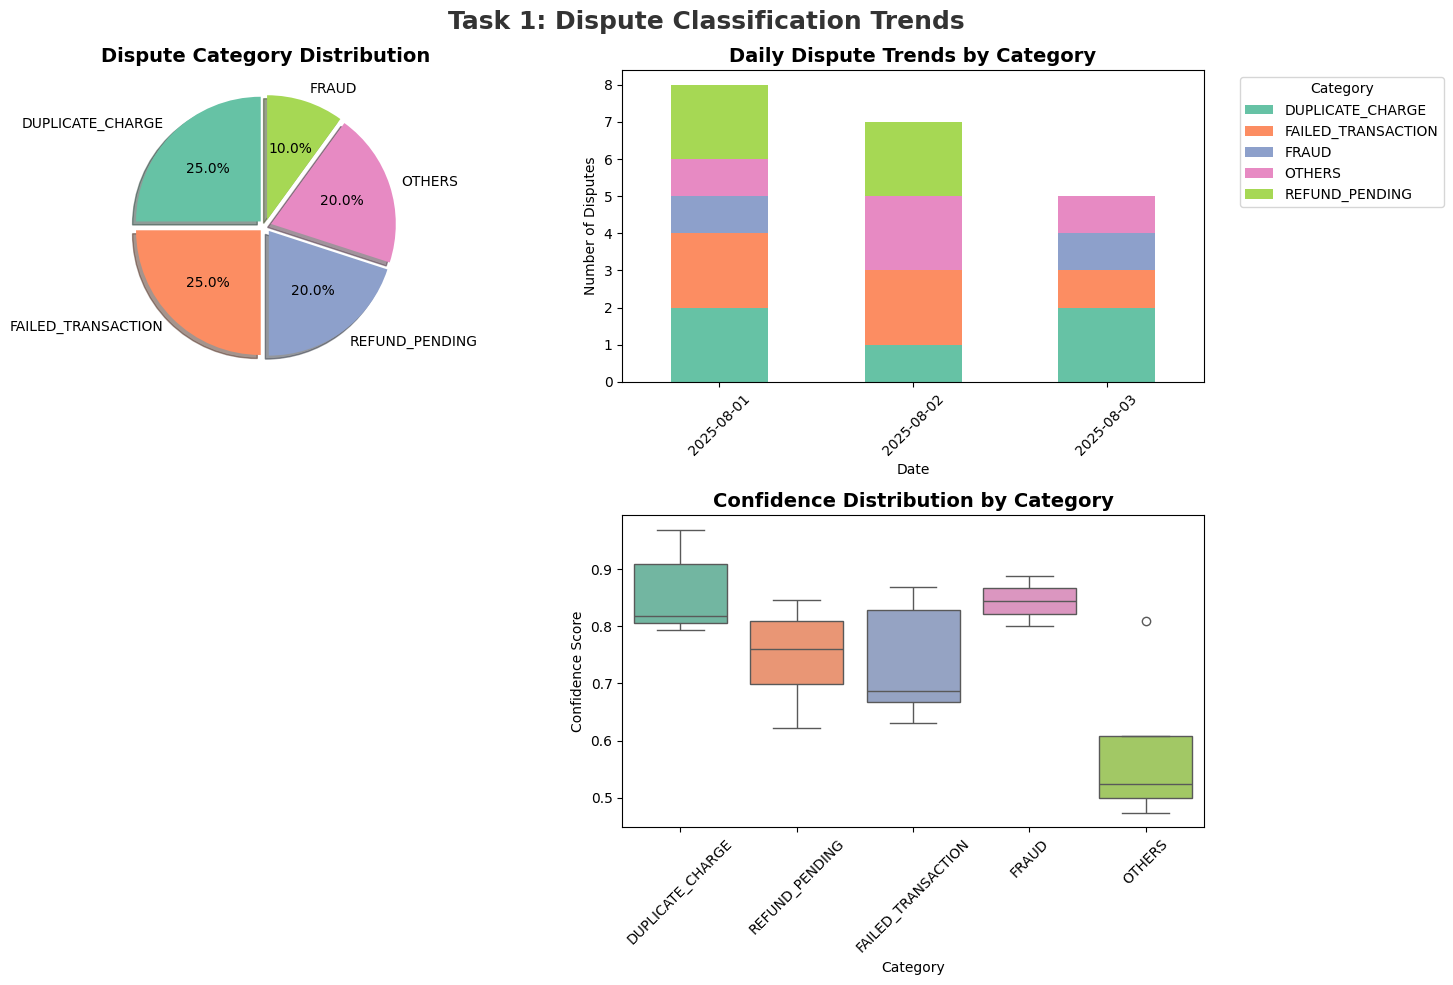

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np


plt.style.use("default") 
sns.set_palette("Set2")   

def visualize_task1_trends(classified_df, transactions_df):

    merged_df = classified_df.merge(
        disputes[['dispute_id', 'created_at']], 
        on='dispute_id', how='left'
    )
    
    merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
    merged_df['date'] = merged_df['created_at'].dt.date
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.delaxes(axes[1, 0]) 
    fig.suptitle('Task 1: Dispute Classification Trends', fontsize=18, fontweight='bold', color="#333333")

    # 1. Category Distribution (Pie Chart)
    category_counts = classified_df['predicted_category'].value_counts()
    axes[0, 0].pie(
        category_counts.values, 
        labels=category_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("Set2"),
        explode=[0.05]*len(category_counts), 
        shadow=True
    )
    axes[0, 0].set_title('Dispute Category Distribution', fontsize=14, fontweight="bold")

    # 2. Disputes by Date (Bar Chart)
    try:
        daily_disputes = merged_df.groupby(['date', 'predicted_category']).size().unstack(fill_value=0)
        if not daily_disputes.empty and daily_disputes.sum().sum() > 0:
            daily_disputes.plot(
                kind='bar', stacked=True, ax=axes[0, 1],
                color=sns.color_palette("Set2")
            )
            axes[0, 1].set_title('Daily Dispute Trends by Category', fontsize=14, fontweight="bold")
            axes[0, 1].set_xlabel('Date')
            axes[0, 1].set_ylabel('Number of Disputes')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Category")
        else:
            category_counts.plot(kind='bar', ax=axes[0, 1], color=sns.color_palette("Set2"))
            axes[0, 1].set_title('Category Distribution (Bar Chart)', fontsize=14, fontweight="bold")
            axes[0, 1].set_xlabel('Category')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].tick_params(axis='x', rotation=45)
    except Exception as e:
        print(f"Error in daily disputes plot: {e}")
        category_counts.plot(kind='bar', ax=axes[0, 1], color=sns.color_palette("Set2"))
        axes[0, 1].set_title('Category Distribution (Bar Chart)', fontsize=14, fontweight="bold")
        axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Confidence Distribution by Category (Box Plot)
    sns.boxplot(
        data=classified_df, x='predicted_category', y='confidence', 
        ax=axes[1, 1], palette="Set2"
    )
    axes[1, 1].set_title('Confidence Distribution by Category', fontsize=14, fontweight="bold")
    axes[1, 1].set_xlabel('Category')
    axes[1, 1].set_ylabel('Confidence Score')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92) 
    plt.savefig('task1_dispute_trends.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_task1_trends(final_classified_df, disputes)